In [3]:
import numpy as np
import os
import math
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import statistics
import random

from IPython.display import Image, HTML, display

%matplotlib inline
from IPython.display import SVG
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from keras.utils import np_utils
from keras.models import model_from_json
from keras.callbacks import EarlyStopping, ModelCheckpoint, BaseLogger, History, Callback

from keras.utils.visualize_util import model_to_dot
from sklearn.metrics import log_loss, accuracy_score

import utils            # data load and cache
import architectures    # models

dict_classes = {'c0': 'safe driving',
            'c1': 'texting - right',
            'c2': 'talking on the phone - right',
            'c3': 'texting - left',
            'c4': 'talking on the phone - left',
            'c5': 'operating the radio',
            'c6': 'drinking',
            'c7': 'reaching behind',
            'c8': 'hair and makeup',
            'c9': 'talking to passenger'}

Using TensorFlow backend.


# Data Import

In [4]:
# 1 - gray, 3 - rgb
color_type = 3 

# input image dimensions
img_rows, img_cols = (32, 32)

train_data, train_target, train_id, driver_id, unique_drivers = utils.read_and_normalize_train_data(img_rows, img_cols, color_type)
test_data, test_id = utils.read_and_normalize_test_data(img_rows, img_cols, color_type)

Restore train from cache!
Train shape: (22424, 3, 32, 32)
22424 train samples
Restore test from cache!
Test shape: (79726, 3, 32, 32)
79726 test samples


# Cross validation

In [3]:
model_id = '160523_2_submit'

nfolds = 5
nb_epoch = 20
batch_size = 32

random_state = 51
patience = 1
b_predit_test = True

np.random.seed(random_state)
model = architectures.create_model(img_rows, img_cols, color_type)

yfull_train = dict()
yfull_test = []
loss = []
val_loss = []

kf = KFold(len(unique_drivers), n_folds=nfolds, shuffle=True, random_state=random_state)

for num_fold, (train_drivers, test_drivers) in enumerate(kf):

    unique_list_train = [unique_drivers[i] for i in train_drivers]
    unique_list_valid = [unique_drivers[i] for i in test_drivers]
    X_train, Y_train, train_index = utils.copy_selected_drivers(train_data, train_target, driver_id, unique_list_train)
    X_valid, Y_valid, test_index = utils.copy_selected_drivers(train_data, train_target, driver_id, unique_list_valid)

    num_fold += 1
    print('Start KFold {}/{}'.format(num_fold, nfolds))
#     print('Train: {}, Validation: {} ({:.1%})'.format(len(X_train), len(X_valid), len(X_valid)/(len(X_valid)+len(X_train))))
    print('Train drivers: ', unique_list_train)
    print('Test drivers: ', unique_list_valid)
    print()
    
    kfold_weights_path = os.path.join('..', 'data', 'cache', 'weights_kfold_' + str(model_id) + '_' + str(num_fold) + '.h5')

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=patience, verbose=1),
        ModelCheckpoint(kfold_weights_path, monitor='val_loss', save_best_only=True, verbose=0),
        architectures.LossHistory(patience=patience)
    ]
    
    model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=nb_epoch,
          shuffle=True, verbose=1, validation_data=(X_valid, Y_valid),
          callbacks=callbacks)
    
    loss.append(callbacks[2].loss)
    val_loss.append(callbacks[2].val_loss)
    
    # load best model to make predictions
    if os.path.isfile(kfold_weights_path):
        model.load_weights(kfold_weights_path)
        
    # validation predictions. !! 2improve: validation set is scored twice !!
    print('\nPrediction for the validation dataset')
    predictions_valid = model.predict(X_valid, batch_size=16*batch_size, verbose=1)
    for i in range(len(test_index)): yfull_train[test_index[i]] = predictions_valid[i]
        
    # test predictions
    if b_predit_test:
        print('\nPrediction for the test dataset') 
        yfull_test.append(model.predict(test_data, batch_size=16*batch_size, verbose=1))
        print()

predictions_valid = utils.get_validation_predictions(train_data, yfull_train)
val_loss_total = log_loss(train_target, predictions_valid)

Start KFold 1/5
Train drivers:  ['p002', 'p014', 'p015', 'p016', 'p021', 'p022', 'p035', 'p041', 'p042', 'p045', 'p047', 'p049', 'p050', 'p051', 'p052', 'p056', 'p064', 'p066', 'p075', 'p081']
Test drivers:  ['p012', 'p024', 'p026', 'p039', 'p061', 'p072']

Train on 17373 samples, validate on 5051 samples
Epoch 1/20
17373/17373 [==============================] - 159s - loss: 1.7601 - val_loss: 1.7516
Epoch 2/20
17373/17373 [==============================] - 154s - loss: 1.0163 - val_loss: 1.5636
Epoch 3/20
17373/17373 [==============================] - 156s - loss: 0.7340 - val_loss: 1.3904
Epoch 4/20
17373/17373 [==============================] - 161s - loss: 0.5609 - val_loss: 1.3870
Epoch 5/20
17373/17373 [==============================] - 160s - loss: 0.4680 - val_loss: 1.5442
Epoch 6/20
17373/17373 [==============================] - 161s - loss: 0.3970 - val_loss: 1.3676
Epoch 7/20
17373/17373 [==============================] - 162s - loss: 0.3521 - val_loss: 1.2877
Epoch 8/20
173

# Results

In [4]:
print('Train loss: {:.4f}; Validation loss: {:.4f}'.format(np.mean(loss), val_loss_total))
print()
print('Model Summary')
model.summary()

Train loss: 0.3745; Validation loss: 0.4891

Model Summary
____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
convolution2d_1 (Convolution2D)    (None, 16, 32, 32)  448         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)    (None, 16, 32, 32)  2320        convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)      (None, 16, 16, 16)  0           convolution2d_2[0][0]            
____________________________________________________________________________________________________
dropout_1 (Dropout)                (None, 16, 16, 16)  0           maxpooling2d_1[0][0]             
________________________________

# Scoring and submission

In [5]:
info_string = 'id_' + str(model_id)\
                + '_loss_' + str(round(val_loss_total, 4)) \
                + '_r_' + str(img_rows) \
                + '_c_' + str(img_cols) \
                + '_folds_' + str(nfolds)
print(info_string)

utils.save_useful_data(predictions_valid, train_id, model, info_string)

if b_predit_test:
    test_res = utils.merge_several_folds_mean(yfull_test)
    utils.create_submission(test_res, test_id, info_string)

id_160523_2_submit_loss_0.4891_r_32_c_32_folds_5


# Model Evaluation

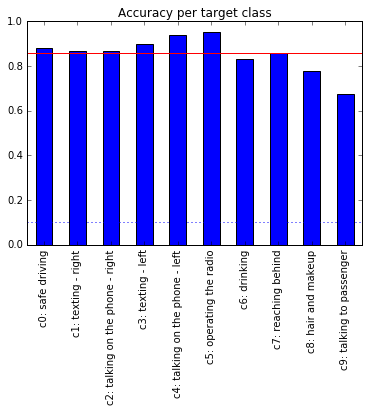

In [12]:
res_class = pd.DataFrame()

for i in range(10):
    mask = train_target[:, i] == 1
    i_dict = 'c' + str(i)
    i_dict = i_dict + ': ' + dict_classes[i_dict]
    
    res_class.loc[i_dict, 'LogLoss'] = log_loss(train_target[mask, :], np.array(predictions_valid)[mask, :])
    res_class.loc[i_dict, 'Accuracy'] = accuracy_score(train_target[mask, :].argmax(axis=1), np.array(predictions_valid)[mask, :].argmax(axis=1))
    
accuracy_val_avg = accuracy_score(train_target.argmax(axis=1), np.array(predictions_valid).argmax(axis=1))

plt.figure();
res_class['Accuracy'].plot(kind='bar', title='Accuracy per target class')
plt.axhline(y=accuracy_val_avg, color='r', label='model')
plt.axhline(y=0.1, color = 'b', label='random', linestyle='dotted')

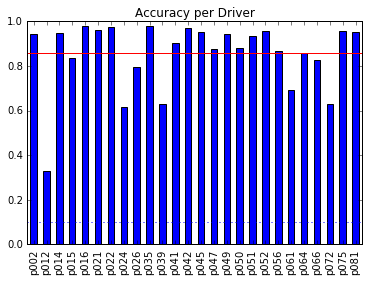

In [13]:
res_driver = pd.DataFrame()

for i in unique_drivers:
    mask = np.array(driver_id) == i
   
    res_driver.loc[i, 'LogLoss'] = log_loss(train_target[mask, :], np.array(predictions_valid)[mask, :])
    res_driver.loc[i, 'Accuracy'] = accuracy_score(train_target[mask, :].argmax(axis=1), np.array(predictions_valid)[mask, :].argmax(axis=1))
    
accuracy_val_avg = accuracy_score(train_target.argmax(axis=1), np.array(predictions_valid).argmax(axis=1))

plt.figure();
res_driver['Accuracy'].plot(kind='bar', title='Accuracy per Driver')
plt.axhline(y=accuracy_val_avg, color='r', label='model')
plt.axhline(y=0.1, color = 'b', label='random', linestyle='dotted')

Normalized confusion matrix


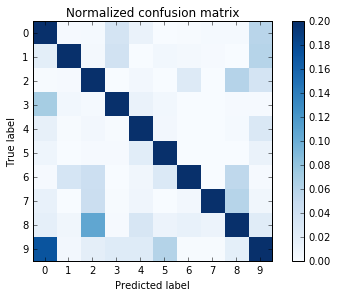

In [47]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmax=0.2)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(cm.shape[0])
    plt.xticks(tick_marks)
    plt.yticks(tick_marks)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Compute confusion matrix
# cm = confusion_matrix(train_target.argmax(axis=1), np.array(predictions_valid).argmax(axis=1))
# np.set_printoptions(precision=2)
# print('Confusion matrix, without normalization')
# print(cm)
# plt.figure()
# plot_confusion_matrix(cm)

# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
# print('Normalized confusion matrix')
# print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

plt.show()

In [8]:
images = pd.DataFrame(data={
        'class': train_target.argmax(axis=1), 
        'id': train_id, 
        'driver': driver_id
        })

print('Difficult Drivers')

for i_driver in res_driver.sort_values(by='LogLoss', ascending=False).head(3).index.tolist():
    sample = images[images['driver']==i_driver].sample(5)
    sample['path'] = sample.apply(lambda x: os.path.join('..', 'data', 'train', 'c' + str(x['class']), x['id']), axis = 1)
    imagesList=''.join( ["<img style='width: 180px; margin: 0px; float: left; border: 1px solid black;' src='%s' />" % s
                          for s in sample['path']
                         ])
    print('\nDriver {}'.format(i_driver))
    display(HTML(imagesList))
    
print('\nEasy Drivers')

for i_driver in res_driver.sort_values(by='LogLoss', ascending=True).head(3).index.tolist():
    sample = images[images['driver']==i_driver].sample(5)
    sample['path'] = sample.apply(lambda x: os.path.join('..', 'data', 'train', 'c' + str(x['class']), x['id']), axis = 1)
    imagesList=''.join( ["<img style='width: 180px; margin: 0px; float: left; border: 1px solid black;' src='%s' />" % s
                          for s in sample['path']
                         ])
    print('\nDriver {}'.format(i_driver))
    display(HTML(imagesList))

Difficult Drivers

Driver p012



Driver p024



Driver p072



Easy Drivers

Driver p035



Driver p022



Driver p016
